<a href="https://www.kaggle.com/code/abdelrahmanmahmoud0/arabic-letters-classification-ipynb?scriptVersionId=153991736" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import csv

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [2]:
def nameToLabel(name):
  return "_".join(name.replace('.', '_').split('_')[1:3])

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(title)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
base_folder = "/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train/"
labels_dict = {}

for category in sorted(os.listdir(base_folder), key=lambda x: int(x)):
    for picture in os.listdir(base_folder + category):
      labels_dict[category] = nameToLabel(picture)
      break
labels_dict

{'0': 'heh_middle',
 '1': 'noon_end',
 '2': 'ain_begin',
 '3': 'ain_end',
 '4': 'ain_middle',
 '5': 'ain_regular',
 '6': 'alif_end',
 '7': 'alif_hamza',
 '8': 'alif_regular',
 '9': 'beh_begin',
 '10': 'beh_end',
 '11': 'beh_middle',
 '12': 'beh_regular',
 '13': 'dal_end',
 '14': 'dal_regular',
 '15': 'feh_begin',
 '16': 'feh_end',
 '17': 'feh_middle',
 '18': 'feh_regular',
 '19': 'heh_begin',
 '20': 'heh_end',
 '21': 'heh_regular',
 '22': 'jeem_begin',
 '23': 'jeem_end',
 '24': 'jeem_middle',
 '25': 'jeem_regular',
 '26': 'kaf_begin',
 '27': 'kaf_end',
 '28': 'kaf_middle',
 '29': 'kaf_regular',
 '30': 'lam_alif',
 '31': 'lam_begin',
 '32': 'lam_end',
 '33': 'lam_middle',
 '34': 'lam_regular',
 '35': 'meem_begin',
 '36': 'meem_end',
 '37': 'meem_middle',
 '38': 'meem_regular',
 '39': 'noon_begin',
 '40': 'noon_middle',
 '41': 'noon_regular',
 '42': 'qaf_begin',
 '43': 'qaf_end',
 '44': 'qaf_middle',
 '45': 'qaf_regular',
 '46': 'raa_end',
 '47': 'raa_regular',
 '48': 'sad_begin',
 '49':

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=lambda x: int(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
class Threshold(object):
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, img):
        return (img > self.threshold).float()

class Dilate(object):
    def __init__(self, radius=3):
        self.radius = radius

    def __call__(self, img):
        kernel = torch.ones(1, 1, self.radius * 2 + 1, self.radius * 2 + 1).to(img.device)
        return F.conv2d(img.unsqueeze(0), kernel, padding=self.radius).squeeze(0)


In [6]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    Threshold(threshold=0.9),
    Dilate(radius=1),
])

dataset = CustomDataset(base_folder, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [7]:
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Label: 56
torch.Size([1, 100, 100])
Label: 1
torch.Size([1, 100, 100])


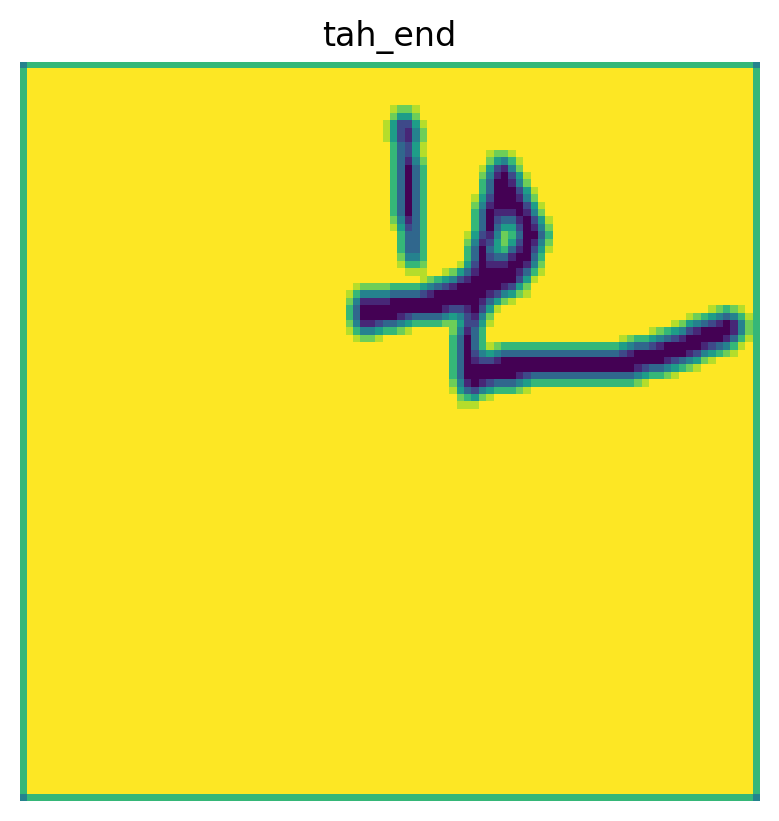

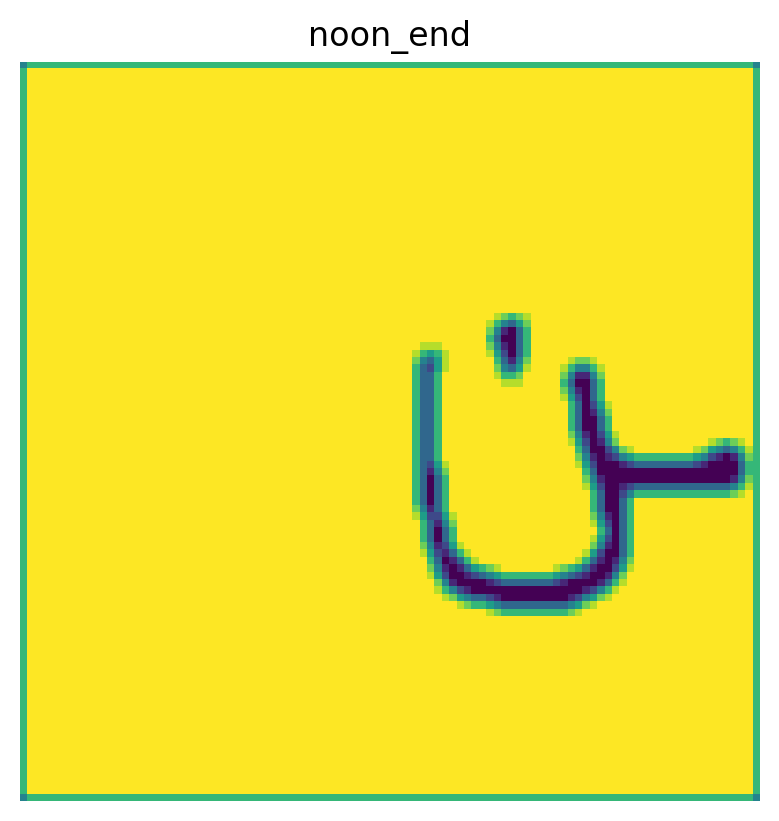

In [8]:
for batch_idx, (images, labels) in enumerate(train_dataloader):
    if batch_idx == 0:
        for i in range(min(2, batch_size)):
            imshow(images[i], title=labels_dict[str(labels[i].item())], normalize=False)
            print(f"Label: {labels[i]}")
            print(images[i].shape)
        break

Label: 1
torch.Size([1, 100, 100])
Label: 26
torch.Size([1, 100, 100])


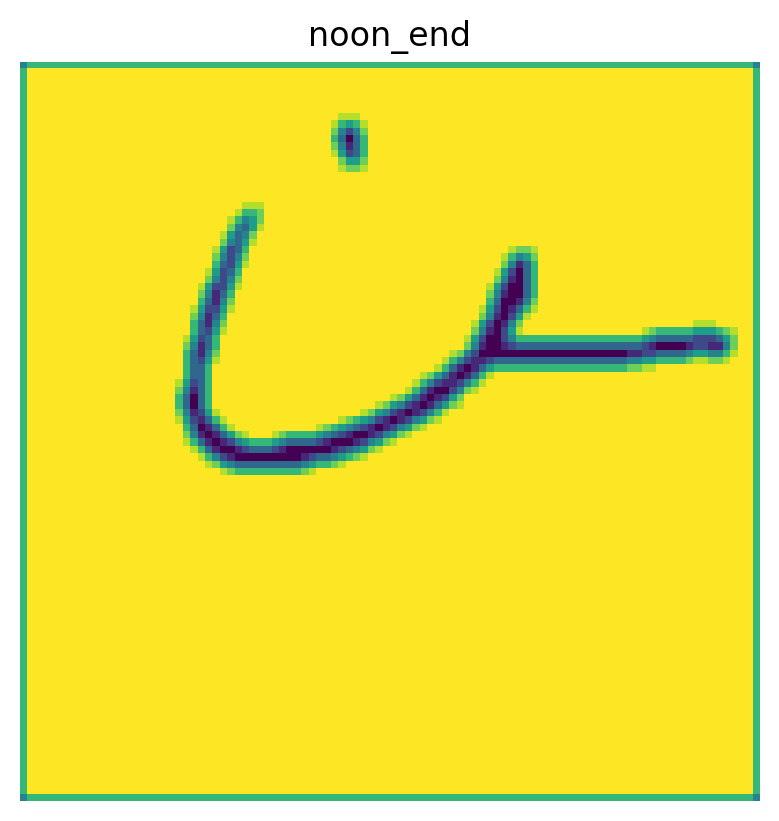

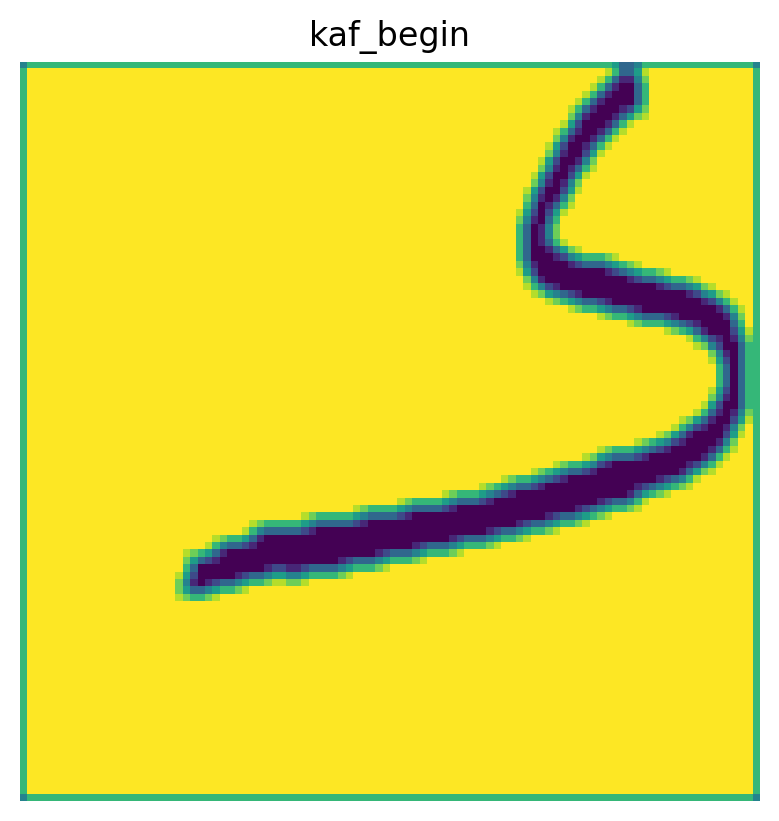

In [9]:
for batch_idx, (images, labels) in enumerate(test_dataloader):
    if batch_idx == 0:
        for i in range(min(2, batch_size)):
            imshow(images[i], title=labels_dict[str(labels[i].item())], normalize=False)
            print(f"Label: {labels[i]}")
            print(images[i].shape)
        break

Label: 6
torch.Size([1, 100, 100])
Label: 38
torch.Size([1, 100, 100])


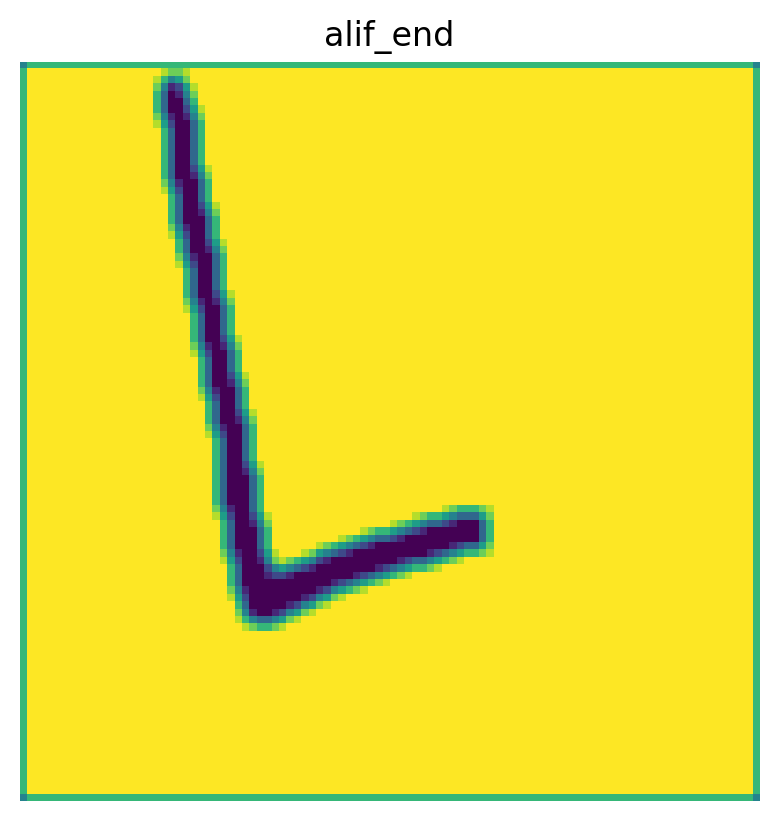

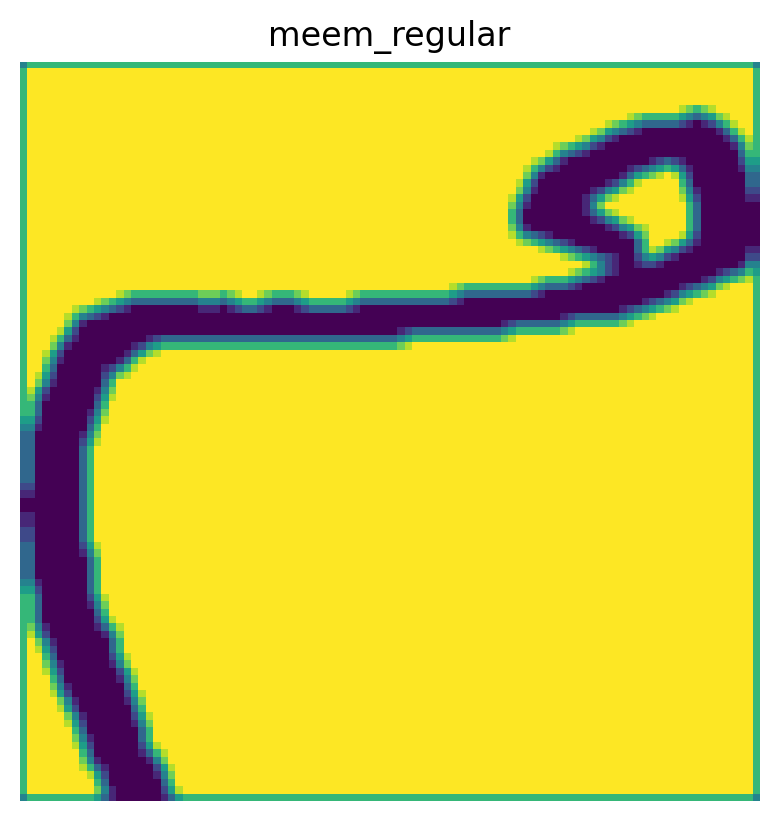

In [10]:
for batch_idx, (images, labels) in enumerate(val_dataloader):
    if batch_idx == 0:
        for i in range(min(2, batch_size)):
            imshow(images[i], title=labels_dict[str(labels[i].item())], normalize=False)
            print(f"Label: {labels[i]}")
            print(images[i].shape)
        break

In [11]:
model = resnet50(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
if(torch.cuda.is_available()):
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print_interval = 10
num_epochs = 50

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct_train = 0
    total_train = 0
    total_batches = len(train_dataloader)

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)

        if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == total_batches:
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{total_batches}, Loss: {loss.item()}")

    train_accuracy = total_correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (val_inputs, val_labels) in enumerate(val_dataloader):
            if torch.cuda.is_available():
                val_inputs = val_inputs.cuda()
                val_labels = val_labels.cuda()

            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            torch.cuda.empty_cache()

            if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == len(val_dataloader):
                avg_val_loss = val_loss / (batch_idx + 1)
                val_accuracy = correct / total
                print(f"Validation Batch {batch_idx + 1}/{len(val_dataloader)}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

    avg_train_loss = running_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss}, Average Validation Loss: {avg_val_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")


Epoch 1/50, Batch 10/67, Loss: 4.173610687255859
Epoch 1/50, Batch 20/67, Loss: 4.166756629943848
Epoch 1/50, Batch 30/67, Loss: 4.080044746398926
Epoch 1/50, Batch 40/67, Loss: 4.014641761779785
Epoch 1/50, Batch 50/67, Loss: 3.9513838291168213
Epoch 1/50, Batch 60/67, Loss: 3.8490633964538574
Epoch 1/50, Batch 67/67, Loss: 3.8364460468292236
Validation Batch 9/9, Validation Loss: 3.80258576075236, Validation Accuracy: 0.14195064629847237
Epoch 1/50, Average Training Loss: 4.046018116509736, Average Validation Loss: 3.80258576075236, Training Accuracy: 0.07031456515992598, Validation Accuracy: 0.14195064629847237
Epoch 2/50, Batch 10/67, Loss: 3.6526174545288086
Epoch 2/50, Batch 20/67, Loss: 3.531256675720215
Epoch 2/50, Batch 30/67, Loss: 3.38212513923645
Epoch 2/50, Batch 40/67, Loss: 3.2589988708496094
Epoch 2/50, Batch 50/67, Loss: 3.106513023376465
Epoch 2/50, Batch 60/67, Loss: 2.979214906692505
Epoch 2/50, Batch 67/67, Loss: 2.846526622772217
Validation Batch 9/9, Validation L

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        if torch.cuda.is_available():
            test_inputs = test_inputs.cuda()
            test_labels = test_labels.cuda()
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9175475687103594


In [14]:
save_path = 'trained_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved at: {save_path}")

Model saved at: trained_model.pth


In [15]:
test_directory = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/'
csv_file_path = 'predictions.csv'

with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    csv_writer.writerow(['ID', 'Label'])

    for filename in sorted(os.listdir(test_directory), key=lambda x: int(x.split('.')[0])):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(test_directory, filename)

            input_image = Image.open(image_path).convert('L')
            input_tensor = transform(input_image).unsqueeze(0)
            input_tensor = input_tensor.cuda()
            

            with torch.no_grad():
                output = model(input_tensor)

            _, predicted_class = torch.max(output, 1)

            csv_writer.writerow([int(filename.split('.')[0]), predicted_class.item()])

print(f"Predictions saved to: {csv_file_path}")

Predictions saved to: predictions.csv
